<a href="https://colab.research.google.com/github/Madhusudhanbandi/EVA-S7/blob/master/EVA_S7_ASSIG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

**Downloading datasets and applying transforms**

In [3]:
train_transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.RandomRotation((-11.0, 11.0)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.RandomRotation((-11.0, 11.0)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
print('No.of images in train set are',len(trainset))
print('No.of images in test set are',len(testset))

No.of images in train set are 50000
No.of images in test set are 10000


In [4]:


SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=4)

    testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
           
        ) 

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
           
        )
        

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=2, bias=False),
            nn.BatchNorm2d(128),
            
            nn.ReLU()
            
        ) 

        #Dilated kernel
        self.dilated =nn.Sequential(
             nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, dilation=2),
             nn.BatchNorm2d(64),
            
            nn.ReLU())

        #Depthwise kernal
        self.depthwise =nn.Sequential(
             nn.Conv2d(128, 64, kernel_size=3, padding=1, groups=1),
             nn.BatchNorm2d(64),
            
            nn.ReLU())
        
        #Convolution kernel
        self.lastcov = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
            
        ) 
        
        #GAP kernel
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) 
        #Fully connected layers
        self.fc1 = nn.Sequential(
                   nn.Linear(256*1*1, 1024)
                   )
        self.fc2 = nn.Sequential( nn.Linear(1024, 10))


       
    def forward(self, x):
      #input block
        x = self.convblock1(x) # output_size = 30 ,RF=3
        # print('after c1',x.shape)
      # C1 block
        x = self.convblock2(x) # output_size = 30 ,RF=5
        # print('after c2',x.shape)
      # Transision T1 block
        x = self.pool1(x)      # output_size = 15 ,RF=7  j=2
        # print('after 1 pool',x.shape)
        x = self.convblock5(x) # output_size = 17 ,RF=11  j=2
        # print('after 1poolconv',x.shape)
      # C2 block
        x = self.dilated(x) # output_size = 15 ,RF=17  j=2
        # print(x.shape)
      # Transision T2 block
        x = self.pool1(x)      # output_size = 7 ,RF=25  j=4
        # print(x.shape)
        x = self.convblock5(x) # output_size = 9 ,RF=32  j=4
        # print(x.shape)
      # C3 block
        x = self.depthwise(x)  # output_size = 9 ,RF=40  j=4
        # print(x.shape)
      # Transision T3 block
        x = self.pool1(x)      # output_size = 4 ,RF=48  j=8
        # print(x.shape)
        x = self.convblock5(x) # output_size = 6 ,RF=64  j=8
        # print(x.shape)
      # C4 block
        x = self.lastcov(x) # output_size = 6 ,RF=80
        # print(x.shape)
        x = self.gap(x)
        # print(x.shape)
        x = x.view(-1, 256*1*1)
        x = self.fc1(x)
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)

        return F.log_softmax(x, dim=-1)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 64, 30, 30]          18,432
       BatchNorm2d-5           [-1, 64, 30, 30]             128
              ReLU-6           [-1, 64, 30, 30]               0
         MaxPool2d-7           [-1, 64, 15, 15]               0
            Conv2d-8          [-1, 128, 17, 17]          73,728
       BatchNorm2d-9          [-1, 128, 17, 17]             256
             ReLU-10          [-1, 128, 17, 17]               0
           Conv2d-11           [-1, 64, 15, 15]          73,728
      BatchNorm2d-12           [-1, 64, 15, 15]             128
             ReLU-13           [-1, 64, 15, 15]               0
        MaxPool2d-14             [

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(trainloader)
  correct = 0
  processed = 0
  # for batch_idx, (data, target) in enumerate(pbar):
    # get samples
  for data, target in trainloader:
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testloader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
    test_acc.append(100. * correct / len(testloader.dataset))

In [11]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)









































  0%|          | 0/3125 [00:00<?, ?it/s]

EPOCH: 0











































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 1.0819, Accuracy: 6100/10000 (61.00%)

EPOCH: 1












































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.8761, Accuracy: 6952/10000 (69.52%)

EPOCH: 2













































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.7677, Accuracy: 7297/10000 (72.97%)

EPOCH: 3














































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.6561, Accuracy: 7704/10000 (77.04%)

EPOCH: 4















































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.6434, Accuracy: 7783/10000 (77.83%)

EPOCH: 5
















































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.6365, Accuracy: 7855/10000 (78.55%)

EPOCH: 6

















































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.5814, Accuracy: 8022/10000 (80.22%)

EPOCH: 7


















































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.6101, Accuracy: 7957/10000 (79.57%)

EPOCH: 8



















































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.6332, Accuracy: 7945/10000 (79.45%)

EPOCH: 9




















































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.5863, Accuracy: 8110/10000 (81.10%)

EPOCH: 10





















































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.6465, Accuracy: 7884/10000 (78.84%)

EPOCH: 11






















































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.6197, Accuracy: 8019/10000 (80.19%)

EPOCH: 12























































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.7302, Accuracy: 7797/10000 (77.97%)

EPOCH: 13
























































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.7210, Accuracy: 7794/10000 (77.94%)

EPOCH: 14

























































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.6564, Accuracy: 8033/10000 (80.33%)

EPOCH: 15


























































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.6704, Accuracy: 8052/10000 (80.52%)

EPOCH: 16



























































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.6292, Accuracy: 8183/10000 (81.83%)

EPOCH: 17




























































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.7237, Accuracy: 7938/10000 (79.38%)

EPOCH: 18





























































  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.9049, Accuracy: 7758/10000 (77.58%)

EPOCH: 19

Test set: Average loss: 0.6991, Accuracy: 8096/10000 (80.96%)



In [0]:
import pandas as pd
df_acc=pd.DataFrame(test_acc,columns=['acc'])

Text(0.5, 1.0, 'Test Accuracy')

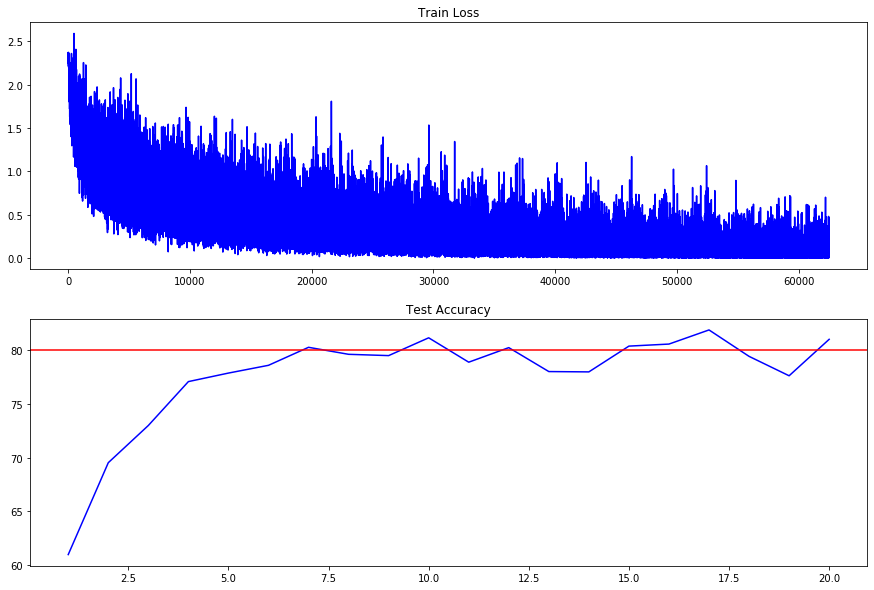

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2,1,figsize=(15,10))
axs[0].plot(train_losses,color='blue')
axs[0].set_title("Train Loss")


axs[1].plot(df_acc.index+1,df_acc['acc'],color='blue')
axs[1].axhline(y=80,color='r')
axs[1].set_title("Test Accuracy")